# Using Satellite Imagery and Machine Learning for Urban Heat Risk Analysis in San Francisco

> Background

    Urban heat risk is a growing concern in many cities around the world, including San Francisco. The rapid urbanization and industrialization of San Francisco. have led to the emergence of urban heat islands, characterized by higher temperatures in densely built-up areas compared to surrounding suburban areas. This phenomenon poses significant health risks to residents, especially during heat waves, and can exacerbate existing socioeconomic inequalities.

> Problem Statement

    The main objective of this project is to assess the urban heat risk in San Francisco. over the past 5 years using satellite imagery and machine learning. The analysis will identify areas with high heat risk and help city planners and policymakers implement targeted interventions to reduce heat exposure, particularly for vulnerable populations.

> Dataset

    For this project, I will use publicly available Landsat 8 satellite imagery through the Google Earth Engine of San Francisco in 2020. The Landsat 8 images provide high-resolution (30-meter) data in multiple spectral bands, including the thermal infrared band, which is essential for calculating land surface temperature. Then I use Python script that utilizes the Google Earth Engine (GEE) Python API to download Landsat 8 satellite imagery for the year 2020 over San Francisco with less than 5% cloud cover. The script loops through each image in the resulting image collection, exports them as GeoTIFF files, and uploads them to a Google Cloud Storage bucket named ‘sf_imagery’. Moreover, GeoTIFF images can be extracted from the specified Google Cloud Storage bucket.

In [1]:
!pip install earthengine-api
!pip install rasterio scikit-image
!pip install lightgbm xgboost
!pip install us
!pip install census
!pip install folium
!pip install rasterio
!pip install geemap
!pip install states

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for states: filename=states-0.2.1-py3-none-any.whl size=10782 sha256=57e66c6df7c747ca44d0767b18565e74468fa9fe51dc57ea859b0480363e3265
  Stored in directory: /root/.cache/pip/wheels/e0/5b/da/e5df3bd1cce7f8d5a50f706c3facd42345a3c42416eef662e9
Successfully built states


In [2]:
import ee
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import rasterio
from io import BytesIO
from scipy import stats, ndimage
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import MeanAbsoluteError, IoU, Precision, Recall

# Machine Learning
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Image processing
from skimage.transform import resize
from skimage.filters import sobel
from skimage.segmentation import watershed
from skimage.measure import regionprops

# Census data
import census
from us import states


# Package Import

In [4]:
ee.Authenticate()
ee.Initialize(project='sfurbanheatisland')

In [5]:
# --- Study Area: San Francisco ---
# Bounding box [west, south, east, north]
SF_BOUNDS = [-122.52, 37.70, -122.35, 37.82]
CITY_NAME = "San Francisco"

In [6]:
START_DATE = '2025-06-01'
END_DATE   = '2025-12-31'
CLOUD_MAX  = 15

In [7]:
# --- Deep Learning Parameters ---
PATCH_SIZE    = 64       # pixels per patch side
PATCH_STRIDE  = 32       # overlap = PATCH_SIZE - PATCH_STRIDE
BATCH_SIZE    = 16
EPOCHS        = 50
LEARNING_RATE = 1e-3
DOWNLOAD_SCALE = 30

In [8]:
CENSUS_API_KEY = 'a9e713a06a0a0f8ec8531e047c9d01e7d9f507d9'  # <-- Get free key at api.census.gov
CENSUS_YEAR    = 2024                   # Latest ACS 5-year
SF_STATE_FIPS  = '06'
SF_COUNTY_FIPS = '075'

In [9]:
OUTPUT_DIR = './sf_heat_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Overview

In this section, it generates a set of satellite-derived vegetation indices including Normalized Difference Vegetation Index (NDVI), Normalized Difference Built-Up Index (NDBI), Normalized Difference Water Index (NDWI), Built-Up Index (BU), Enhanced Vegetation Index (EVI), and Soil-Adjusted Vegetation Index (SAVI) for a region of interest in San Francisco.

The code first defines the region of San Francisco and filters the Landsat-8 image collection to get the image on September 30th, 2022, with less than 20% cloud cover. It then calculates the median of the filtered image collection and computes the vegetation indices using the normalized difference or expression methods. The vegetation indices are clipped to the region of interest, and then added to a Folium map, along with the San Francisco neighborhood boundaries as a GeoJSON layer. The final output is an interactive map that displays the vegetation indices for the selected area.

# **1. DATA COLLECTION (Google Earth Engine)**

In [10]:
region = ee.Geometry.Rectangle(SF_BOUNDS)

# --- 1.1  Image composite ---
# Merge Landsat 8 & 9 for more temporal coverage
landsat = (
    ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
      .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'))
      .filterBounds(region)
      .filterDate(START_DATE, END_DATE)
      .filter(ee.Filter.lt('CLOUD_COVER', CLOUD_MAX))
)
n_images = landsat.size().getInfo()
print(f"  Found {n_images} images (cloud < {CLOUD_MAX}%)")

composite = landsat.median()

  Found 13 images (cloud < 15%)


In [11]:
# --- 1.2  Band scaling (Collection 2 Level-2 scale factors) ---
# Reflectance bands: DN * 0.0000275 - 0.2
# Thermal band (ST_B10): DN * 0.00341802 + 149.0  (Kelvin)

def scale_bands(img):
    """Apply Landsat C2L2 scale factors."""
    optical = img.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']) \
                 .multiply(0.0000275).add(-0.2).clamp(0, 1)
    thermal = img.select('ST_B10').multiply(0.00341802).add(149.0)  # Kelvin
    return optical.addBands(thermal)

composite_scaled = scale_bands(composite)

In [12]:
# --- 1.3  Spectral Indices ---
b2 = composite_scaled.select('SR_B2')  # Blue
b3 = composite_scaled.select('SR_B3')  # Green
b4 = composite_scaled.select('SR_B4')  # Red
b5 = composite_scaled.select('SR_B5')  # NIR
b6 = composite_scaled.select('SR_B6')  # SWIR1
b7 = composite_scaled.select('SR_B7')  # SWIR2
thermal_k = composite_scaled.select('ST_B10')

ndvi  = b5.subtract(b4).divide(b5.add(b4)).rename('NDVI')
ndbi  = b6.subtract(b5).divide(b6.add(b5)).rename('NDBI')
ndwi  = b3.subtract(b6).divide(b3.add(b6)).rename('NDWI')   # Modified NDWI (Xu 2006)
bu    = ndbi.subtract(ndvi).rename('BU')                      # Built-up index
lst_c = thermal_k.subtract(273.15).rename('LST')              # Celsius

# EVI (Enhanced Vegetation Index)
evi = b5.subtract(b4).divide(
    b5.add(b4.multiply(6)).subtract(b2.multiply(7.5)).add(1)
).multiply(2.5).rename('EVI')

# Stack all bands into one image
final_image = (
    b2.rename('Blue')
      .addBands(b3.rename('Green'))
      .addBands(b4.rename('Red'))
      .addBands(b5.rename('NIR'))
      .addBands(b6.rename('SWIR1'))
      .addBands(b7.rename('SWIR2'))
      .addBands(ndvi)
      .addBands(ndbi)
      .addBands(ndwi)
      .addBands(bu)
      .addBands(evi)
      .addBands(lst_c)
)

BAND_NAMES = ['Blue','Green','Red','NIR','SWIR1','SWIR2',
              'NDVI','NDBI','NDWI','BU','EVI','LST']
FEATURE_BANDS = BAND_NAMES[:-1]   # everything except LST
N_FEATURES    = len(FEATURE_BANDS)

print(f"  Bands: {', '.join(BAND_NAMES)}")
print(f"  Features (model input): {N_FEATURES}")
print(f"  Target: LST (land surface temperature)")


  Bands: Blue, Green, Red, NIR, SWIR1, SWIR2, NDVI, NDBI, NDWI, BU, EVI, LST
  Features (model input): 11
  Target: LST (land surface temperature)


In [13]:
url = final_image.clip(region).getDownloadURL({
    'region': region.coordinates().getInfo(),
    'scale': DOWNLOAD_SCALE,
    'format': 'GEO_TIFF',
    'bands': BAND_NAMES
})

response = requests.get(url)
# GEE sometimes returns a JSON redirect
try:
    js = response.json()
    if 'downloadUrl' in js:
        response = requests.get(js['downloadUrl'])
except ValueError:
    pass

print(f"  Downloaded {len(response.content)/1024/1024:.1f} MB")

  Downloaded 15.8 MB
  Image shape: 12 bands × 446 rows × 632 cols
  LST range (valid pixels): 13.3 – 41.7 °C
  LST mean: 26.1 °C


In [14]:
# --- 1.5  Read into numpy ---
with rasterio.open(BytesIO(response.content)) as src:
    img_array = src.read().astype(np.float32)   # (bands, H, W)
    transform = src.transform
    crs       = src.crs

n_bands, HEIGHT, WIDTH = img_array.shape
print(f"  Image shape: {n_bands} bands × {HEIGHT} rows × {WIDTH} cols")

# Quick sanity check on LST
lst_layer = img_array[-1]
lst_valid = lst_layer[(lst_layer > -10) & (lst_layer < 70)]
print(f"  LST range (valid pixels): {lst_valid.min():.1f} – {lst_valid.max():.1f} °C")
print(f"  LST mean: {lst_valid.mean():.1f} °C")

  Image shape: 12 bands × 446 rows × 632 cols
  LST range (valid pixels): 13.3 – 41.7 °C
  LST mean: 26.1 °C


# **2. PREPROCESSING & PATCH EXTRACTION**

In [15]:
invalid_mask = (
    (img_array[0] == 0) |             # blue band = 0 → fill pixel
    (lst_layer < -10) |                # unrealistic cold
    (lst_layer > 70)                   # unrealistic hot
)
img_array[:, invalid_mask] = np.nan
pct_valid = (~invalid_mask).sum() / invalid_mask.size * 100
print(f"  Valid pixels: {pct_valid:.1f}%")

  Valid pixels: 100.0%


In [18]:
print(f"  Extracting {PATCH_SIZE}×{PATCH_SIZE} patches (stride={PATCH_STRIDE}) …")

feature_img = img_array[:-1]  # (N_FEATURES, H, W)
target_img  = img_array[-1:]  # (1, H, W)  — LST only

patches_X = []
patches_Y = []
patch_coords = []   # (row, col) of top-left corner — for reassembly later

for r in range(0, HEIGHT - PATCH_SIZE + 1, PATCH_STRIDE):
    for c in range(0, WIDTH - PATCH_SIZE + 1, PATCH_STRIDE):
        x_patch = feature_img[:, r:r+PATCH_SIZE, c:c+PATCH_SIZE]
        y_patch = target_img[:, r:r+PATCH_SIZE, c:c+PATCH_SIZE]

        # Reject patches with > 20% NaN
        nan_frac = np.isnan(x_patch).sum() / x_patch.size
        if nan_frac > 0.2:
            continue

        # Fill remaining NaNs per channel with channel median
        for ch in range(x_patch.shape[0]):
            mask = np.isnan(x_patch[ch])
            if mask.any():
                x_patch[ch, mask] = np.nanmedian(x_patch[ch])

        y_nan = np.isnan(y_patch[0])
        if y_nan.any():
            y_patch[0, y_nan] = np.nanmedian(y_patch[0])

        # Transpose to (H, W, C) for TensorFlow
        patches_X.append(x_patch.transpose(1, 2, 0))
        patches_Y.append(y_patch.transpose(1, 2, 0))
        patch_coords.append((r, c))

patches_X = np.array(patches_X, dtype=np.float32)
patches_Y = np.array(patches_Y, dtype=np.float32)
patch_coords = np.array(patch_coords)

print(f"  Extracted {len(patches_X)} valid patches")
print(f"  X shape: {patches_X.shape}  (samples, H, W, features)")
print(f"  Y shape: {patches_Y.shape}  (samples, H, W, 1)")

  Extracting 64×64 patches (stride=32) …
  Extracted 216 valid patches
  X shape: (216, 64, 64, 11)  (samples, H, W, features)
  Y shape: (216, 64, 64, 1)  (samples, H, W, 1)


In [19]:
print("  Normalising features (z-score per channel) …")

channel_means = patches_X.mean(axis=(0,1,2))
channel_stds  = patches_X.std(axis=(0,1,2)) + 1e-8

patches_X_norm = (patches_X - channel_means) / channel_stds

# Normalise LST target to [0, 1] for easier training
lst_min = patches_Y.min()
lst_max = patches_Y.max()
patches_Y_norm = (patches_Y - lst_min) / (lst_max - lst_min + 1e-8)

print(f"  LST normalisation: [{lst_min:.1f}, {lst_max:.1f}] °C → [0, 1]")


  Normalising features (z-score per channel) …
  LST normalisation: [13.7, 41.7] °C → [0, 1]


In [20]:
print("  Creating heat-risk segmentation labels …")

# Global thresholds from all valid LST pixels
t_low, t_high = np.percentile(lst_valid, [33, 67])
print(f"  Risk thresholds: Low < {t_low:.1f} °C | Med < {t_high:.1f} °C | High ≥ {t_high:.1f} °C")

N_CLASSES = 3
patches_Y_seg = np.zeros((*patches_Y.shape[:3], N_CLASSES), dtype=np.float32)
patches_Y_seg[..., 0] = (patches_Y[..., 0] < t_low).astype(np.float32)          # low
patches_Y_seg[..., 1] = ((patches_Y[..., 0] >= t_low) &
                          (patches_Y[..., 0] < t_high)).astype(np.float32)         # medium
patches_Y_seg[..., 2] = (patches_Y[..., 0] >= t_high).astype(np.float32)         # high

print(f"  Segmentation labels shape: {patches_Y_seg.shape}")


  Creating heat-risk segmentation labels …
  Risk thresholds: Low < 19.7 °C | Med < 31.6 °C | High ≥ 31.6 °C
  Segmentation labels shape: (216, 64, 64, 3)


In [21]:
idx = np.arange(len(patches_X_norm))
np.random.shuffle(idx)

n_train = int(0.7 * len(idx))
n_val   = int(0.15 * len(idx))

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

X_train, X_val, X_test = patches_X_norm[train_idx], patches_X_norm[val_idx], patches_X_norm[test_idx]
# Regression targets
Yr_train, Yr_val, Yr_test = patches_Y_norm[train_idx], patches_Y_norm[val_idx], patches_Y_norm[test_idx]
# Segmentation targets
Ys_train, Ys_val, Ys_test = patches_Y_seg[train_idx], patches_Y_seg[val_idx], patches_Y_seg[test_idx]

print(f"\n  Split: {len(train_idx)} train / {len(val_idx)} val / {len(test_idx)} test")



  Split: 151 train / 32 val / 33 test


# **3. CNN REGRESSION MODEL (Predict LST)**

In [24]:

print("""
Architecture:
  Input (64×64×11) → Conv blocks → Global Average Pool → Dense → LST

This model learns the relationship between spectral features and
land surface temperature.  It's a simpler model that validates
whether CNN features can predict heat intensity.
""")


Architecture:
  Input (64×64×11) → Conv blocks → Global Average Pool → Dense → LST

This model learns the relationship between spectral features and
land surface temperature.  It's a simpler model that validates
whether CNN features can predict heat intensity.



In [25]:

def build_cnn_regressor(input_shape):
    """Simple CNN that predicts mean patch LST from spectral bands."""
    inputs = Input(shape=input_shape, name='spectral_input')

    # Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Regression head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1, activation='sigmoid', name='lst_output')(x)

    return Model(inputs, x, name='CNN_Regressor')

cnn_reg = build_cnn_regressor((PATCH_SIZE, PATCH_SIZE, N_FEATURES))
cnn_reg.summary()

cnn_reg.compile(
    optimizer=Adam(LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

# Regression target: mean LST per patch (scalar)
Yr_train_mean = Yr_train.mean(axis=(1,2))  # (N, 1)
Yr_val_mean   = Yr_val.mean(axis=(1,2))
Yr_test_mean  = Yr_test.mean(axis=(1,2))

callbacks_reg = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-6, monitor='val_loss')
]

print("Training CNN regressor …")
history_reg = cnn_reg.fit(
    X_train, Yr_train_mean,
    validation_data=(X_val, Yr_val_mean),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_reg,
    verbose=1
)

Model: "CNN_Regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spectral_input (InputLayer)     │ (None, 64, 64, 11)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lst_output (Dense)              │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,329 (591.13 KB)

 Trainable params: 150,689 (588.63 KB)

 Non-trainable params: 640 (2.50 KB)

Training CNN regressor …
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - loss: 0.0514 - mae: 0.1761 - val_loss: 0.0244 - val_mae: 0.1248 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step - loss: 0.0194 - mae: 0.1134 - val_loss: 0.0202 - val_mae: 0.1318 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 415ms/step - loss: 0.0115 - mae: 0.0857 - val_loss: 0.0062 - val_mae: 0.0618 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0097 - mae: 0.0750 - val_loss: 0.0034 - val_mae: 0.0425 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 546ms/step - loss: 0.0084 - mae: 0.0731 - val_loss: 0.0084 - val_mae: 0.0815 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 735ms/step - loss: 0.0088 - mae: 0.0693 - val_loss: 0.0033 - val_mae: 0.0455 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - loss: 0.0067 - mae: 0.0643 - val_loss: 0.0084 - val_mae: 0.0753 - lear

In [27]:
# --- Evaluate ---
pred_test_norm = cnn_reg.predict(X_test).flatten()
pred_test_c    = pred_test_norm * (lst_max - lst_min) + lst_min
actual_test_c  = Yr_test_mean.flatten() * (lst_max - lst_min) + lst_min

reg_mae  = mean_absolute_error(actual_test_c, pred_test_c)
reg_rmse = np.sqrt(mean_squared_error(actual_test_c, pred_test_c))
reg_r2   = r2_score(actual_test_c, pred_test_c)

print(f"\n  CNN Regressor — Test Results:")
print(f"    MAE  = {reg_mae:.2f} °C")
print(f"    RMSE = {reg_rmse:.2f} °C")
print(f"    R²   = {reg_r2:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step

  CNN Regressor — Test Results:
    MAE  = 1.07 °C
    RMSE = 1.25 °C
    R²   = 0.963


# **4. U-NET SEGMENTATION MODEL (Pixel-wise Heat Risk)**

In [28]:
print("""
Architecture:
  Encoder (down-sampling) → Bottleneck → Decoder (up-sampling + skip connections)

This is the core model.  It classifies EVERY PIXEL into one of three
heat-risk classes: Low / Medium / High.  Skip connections preserve
spatial detail so the output map is sharp, not blurry.
""")


Architecture:
  Encoder (down-sampling) → Bottleneck → Decoder (up-sampling + skip connections)

This is the core model.  It classifies EVERY PIXEL into one of three
heat-risk classes: Low / Medium / High.  Skip connections preserve
spatial detail so the output map is sharp, not blurry.



In [29]:
def conv_block(x, filters, dropout=0.2):
    """Two conv layers + batch norm + optional dropout."""
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x

def build_unet(input_shape, n_classes=3):
    """
    U-Net for heat-risk segmentation.

    Parameters
    ----------
    input_shape : tuple  e.g. (64, 64, 11)
    n_classes   : int    number of risk categories

    Returns
    -------
    keras.Model with softmax output (H, W, n_classes)
    """
    inputs = Input(shape=input_shape, name='spectral_input')

    # ---- Encoder ----
    e1 = conv_block(inputs, 32,  dropout=0.1)     # 64×64
    p1 = layers.MaxPooling2D(2)(e1)                # 32×32

    e2 = conv_block(p1, 64,  dropout=0.1)          # 32×32
    p2 = layers.MaxPooling2D(2)(e2)                # 16×16

    e3 = conv_block(p2, 128, dropout=0.2)          # 16×16
    p3 = layers.MaxPooling2D(2)(e3)                # 8×8

    e4 = conv_block(p3, 256, dropout=0.2)          # 8×8
    p4 = layers.MaxPooling2D(2)(e4)                # 4×4

    # ---- Bottleneck ----
    b = conv_block(p4, 512, dropout=0.3)           # 4×4

    # ---- Decoder ----
    u4 = layers.UpSampling2D(2)(b)                 # 8×8
    u4 = layers.Concatenate()([u4, e4])            # skip connection
    d4 = conv_block(u4, 256, dropout=0.2)

    u3 = layers.UpSampling2D(2)(d4)                # 16×16
    u3 = layers.Concatenate()([u3, e3])
    d3 = conv_block(u3, 128, dropout=0.2)

    u2 = layers.UpSampling2D(2)(d3)                # 32×32
    u2 = layers.Concatenate()([u2, e2])
    d2 = conv_block(u2, 64,  dropout=0.1)

    u1 = layers.UpSampling2D(2)(d2)                # 64×64
    u1 = layers.Concatenate()([u1, e1])
    d1 = conv_block(u1, 32,  dropout=0.1)

    # ---- Output ----
    outputs = layers.Conv2D(n_classes, 1, activation='softmax', name='risk_map')(d1)

    return Model(inputs, outputs, name='UNet_HeatRisk')


unet = build_unet((PATCH_SIZE, PATCH_SIZE, N_FEATURES), n_classes=N_CLASSES)
unet.summary()

unet.compile(
    optimizer=Adam(LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_seg = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor='val_loss')
]

print("Training U-Net segmentation …")
history_seg = unet.fit(
    X_train, Ys_train,
    validation_data=(X_val, Ys_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_seg,
    verbose=1
)

Model: "UNet_HeatRisk"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectral_input      │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      3,200 │ spectral_input[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ dropout_4[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ dropout_5[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_10[0][0] 

 Total params: 7,860,803 (29.99 MB)

 Trainable params: 7,854,915 (29.96 MB)

 Non-trainable params: 5,888 (23.00 KB)

Training U-Net segmentation …
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5671 - loss: 1.1010 - val_accuracy: 0.6185 - val_loss: 0.8528 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.8007 - loss: 0.4642 - val_accuracy: 0.5757 - val_loss: 1.3161 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8319 - loss: 0.3872 - val_accuracy: 0.5846 - val_loss: 1.3588 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8425 - loss: 0.3631 - val_accuracy: 0.6000 - val_loss: 0.9325 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8541 - loss: 0.3369 - val_accuracy: 0.5884 - val_loss: 0.9312 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8716 - loss: 0.3025 - val_accuracy: 0.6590 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8683 -

In [31]:
# --- Evaluate ---
seg_loss, seg_acc = unet.evaluate(X_test, Ys_test, verbose=0)
print(f"\n  U-Net — Test Results:")
print(f"    Loss     = {seg_loss:.4f}")
print(f"    Accuracy = {seg_acc:.3f}")

# Per-class IoU
pred_seg = unet.predict(X_test)
pred_cls = pred_seg.argmax(axis=-1)
true_cls = Ys_test.argmax(axis=-1)

class_names = ['Low Risk', 'Medium Risk', 'High Risk']
for c in range(N_CLASSES):
    intersection = ((pred_cls == c) & (true_cls == c)).sum()
    union        = ((pred_cls == c) | (true_cls == c)).sum()
    iou = intersection / (union + 1e-8)
    print(f"    IoU ({class_names[c]}): {iou:.3f}")


  U-Net — Test Results:
    Loss     = 0.2473
    Accuracy = 0.906
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step
    IoU (Low Risk): 0.984
    IoU (Medium Risk): 0.743
    IoU (High Risk): 0.774


# **5. FULL-IMAGE RISK MAP**

In [32]:
# Predict on ALL patches (not just test set) and stitch back
print("  Running U-Net inference on all patches …")

all_preds = unet.predict(patches_X_norm, batch_size=BATCH_SIZE)
# all_preds shape: (N_patches, 64, 64, 3)

# Reassemble into full image
risk_map   = np.zeros((HEIGHT, WIDTH, N_CLASSES), dtype=np.float32)
count_map  = np.zeros((HEIGHT, WIDTH, 1), dtype=np.float32)

for i, (r, c) in enumerate(patch_coords):
    risk_map[r:r+PATCH_SIZE, c:c+PATCH_SIZE, :] += all_preds[i]
    count_map[r:r+PATCH_SIZE, c:c+PATCH_SIZE, :] += 1

# Average overlapping predictions
count_map[count_map == 0] = 1
risk_map /= count_map

# Argmax → class map
risk_class_map = risk_map.argmax(axis=-1)   # 0=low, 1=med, 2=high
risk_class_map[count_map[..., 0] == 1e-8] = -1  # mask un-predicted areas

high_risk_pct = (risk_class_map == 2).sum() / (count_map[..., 0] > 0).sum() * 100
print(f"  High-risk area: {high_risk_pct:.1f}% of city")
print(f"  Risk map shape: {risk_class_map.shape}")

  Running U-Net inference on all patches …
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
  High-risk area: 32.3% of city
  Risk map shape: (446, 632)


# **6. DEMOGRAPHIC VULNERABILITY OVERLAY**

In [33]:
def fetch_census_data(api_key, state_fips, county_fips, year=2021):
    """
    Pull ACS 5-year tract-level data for vulnerability indicators.

    Variables:
      B01001_001E  - Total population
      B19013_001E  - Median household income
      B17001_002E  - Population below poverty level
      B01001_020E+ - Population 65+ (simplified)
      B03002_001E  - Total (for race/ethnicity)
      B03002_003E  - White alone non-Hispanic
      B25040_001E  - House heating fuel (proxy for AC access)
    """
    c = Census(api_key, year=year)

    variables = [
        'NAME',
        'B01001_001E',  # total pop
        'B19013_001E',  # median income
        'B17001_002E',  # below poverty
        'B01001_020E',  # male 65-66 (proxy start for elderly)
        'B01001_021E','B01001_022E','B01001_023E','B01001_024E','B01001_025E',
        'B01001_044E',  # female 65-66
        'B01001_045E','B01001_046E','B01001_047E','B01001_048E','B01001_049E',
        'B03002_003E',  # white non-hispanic
    ]

    data = c.acs5.state_county_tract(
        fields=variables,
        state_fips=state_fips,
        county_fips=county_fips,
        tract='*'
    )

    df = pd.DataFrame(data)

    # --- Derive vulnerability indicators ---
    df['total_pop']     = pd.to_numeric(df['B01001_001E'], errors='coerce')
    df['median_income'] = pd.to_numeric(df['B19013_001E'], errors='coerce')
    df['poverty_pop']   = pd.to_numeric(df['B17001_002E'], errors='coerce')
    df['white_nh']      = pd.to_numeric(df['B03002_003E'], errors='coerce')

    # Elderly (sum of 65+ age groups — both male & female columns)
    elderly_cols = ['B01001_020E','B01001_021E','B01001_022E','B01001_023E',
                    'B01001_024E','B01001_025E','B01001_044E','B01001_045E',
                    'B01001_046E','B01001_047E','B01001_048E','B01001_049E']
    for col in elderly_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['elderly_pop'] = df[elderly_cols].sum(axis=1)

    # Rates
    df['poverty_rate']  = df['poverty_pop'] / df['total_pop'].replace(0, np.nan)
    df['elderly_rate']  = df['elderly_pop'] / df['total_pop'].replace(0, np.nan)
    df['minority_rate'] = 1 - (df['white_nh'] / df['total_pop'].replace(0, np.nan))

    # Composite vulnerability index (equal-weight z-scores)
    for col in ['poverty_rate', 'elderly_rate', 'minority_rate']:
        df[f'{col}_z'] = (df[col] - df[col].mean()) / (df[col].std() + 1e-8)

    df['vulnerability_index'] = (
        df['poverty_rate_z'] + df['elderly_rate_z'] + df['minority_rate_z']
    ) / 3

    df['tract'] = df['tract'].astype(str)

    return df[['NAME','tract','total_pop','median_income',
               'poverty_rate','elderly_rate','minority_rate',
               'vulnerability_index']].dropna()

In [35]:
# --- 6.1  Fetch census data ---
print("  Fetching Census ACS data …")
try:
    census_df = fetch_census_data(CENSUS_API_KEY, SF_STATE_FIPS, SF_COUNTY_FIPS, CENSUS_YEAR)
    print(f"  Loaded {len(census_df)} census tracts")
    HAS_CENSUS = True
except Exception as e:
    print(f"  ⚠ Census API error: {e}")
    print("  → Generating synthetic demographic data for demonstration …")
    HAS_CENSUS = False

    # Synthetic fallback (for demo / if API key not set)
    np.random.seed(RANDOM_SEED)
    n_tracts = 195  # approximate SF tract count
    census_df = pd.DataFrame({
        'tract': [f'{i:06d}' for i in range(n_tracts)],
        'total_pop':        np.random.randint(1000, 8000, n_tracts),
        'median_income':    np.random.normal(85000, 35000, n_tracts).clip(15000, 250000),
        'poverty_rate':     np.random.beta(2, 8, n_tracts),
        'elderly_rate':     np.random.beta(2, 8, n_tracts),
        'minority_rate':    np.random.beta(5, 3, n_tracts),
        'vulnerability_index': np.random.normal(0, 1, n_tracts),
    })

  Fetching Census ACS data …
  ⚠ Census API error: name 'Census' is not defined
  → Generating synthetic demographic data for demonstration …


In [36]:
# --- 6.2  Spatial join (simplified pixel sampling) ---
# In a full analysis you'd use geopandas with tract shapefiles.
# Here we sample the risk map at grid points corresponding to tracts.
print("  Linking tracts to risk map …")

# Approximate: distribute tract centroids evenly across the image
n_tracts = len(census_df)
np.random.seed(RANDOM_SEED)
sample_rows = np.random.randint(0, HEIGHT, n_tracts)
sample_cols = np.random.randint(0, WIDTH,  n_tracts)

tract_temps = []
tract_risks = []
for r, c_col in zip(sample_rows, sample_cols):
    # Average a small 5×5 neighbourhood
    r0, r1 = max(0, r-2), min(HEIGHT, r+3)
    c0, c1 = max(0, c_col-2), min(WIDTH, c_col+3)
    patch_risk = risk_class_map[r0:r1, c0:c1]
    if patch_risk.size > 0:
        tract_risks.append(np.mean(patch_risk))
    else:
        tract_risks.append(np.nan)

    # Get LST from original image
    lst_patch = lst_layer[r0:r1, c0:c1]
    valid = lst_patch[(lst_patch > -10) & (lst_patch < 70)]
    tract_temps.append(np.mean(valid) if len(valid) > 0 else np.nan)

census_df['mean_lst']   = tract_temps
census_df['mean_risk']  = tract_risks
census_df = census_df.dropna(subset=['mean_lst', 'mean_risk'])

  Linking tracts to risk map …


In [37]:
# --- 6.3  Correlation analysis ---
print("\n  Correlation analysis:")
corr, pval = stats.pearsonr(census_df['vulnerability_index'], census_df['mean_lst'])
print(f"    Vulnerability vs LST:  r = {corr:.3f},  p = {pval:.4f}")

corr_inc, pval_inc = stats.pearsonr(census_df['median_income'], census_df['mean_lst'])
print(f"    Income vs LST:         r = {corr_inc:.3f},  p = {pval_inc:.4f}")

corr_pov, pval_pov = stats.pearsonr(census_df['poverty_rate'], census_df['mean_lst'])
print(f"    Poverty rate vs LST:   r = {corr_pov:.3f},  p = {pval_pov:.4f}")

# High-vulnerability tracts
high_vuln = census_df[census_df['vulnerability_index'] > census_df['vulnerability_index'].quantile(0.75)]
low_vuln  = census_df[census_df['vulnerability_index'] < census_df['vulnerability_index'].quantile(0.25)]

print(f"\n    High-vulnerability tracts mean LST: {high_vuln['mean_lst'].mean():.1f} °C")
print(f"    Low-vulnerability tracts mean LST:  {low_vuln['mean_lst'].mean():.1f} °C")
print(f"    Difference: {high_vuln['mean_lst'].mean() - low_vuln['mean_lst'].mean():.1f} °C")



  Correlation analysis:
    Vulnerability vs LST:  r = 0.058,  p = 0.4244
    Income vs LST:         r = -0.096,  p = 0.1839
    Poverty rate vs LST:   r = 0.120,  p = 0.0943

    High-vulnerability tracts mean LST: 27.1 °C
    Low-vulnerability tracts mean LST:  26.0 °C
    Difference: 1.1 °C


# **7. VISUALISATIONS**

In [38]:
# ---------- 7.1  Training curves ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Regressor
ax = axes[0]
ax.plot(history_reg.history['loss'], label='Train')
ax.plot(history_reg.history['val_loss'], label='Val')
ax.set_title('CNN Regressor — Loss', fontweight='bold')
ax.set_xlabel('Epoch');  ax.set_ylabel('MSE Loss')
ax.legend(); ax.grid(alpha=0.3)

# U-Net
ax = axes[1]
ax.plot(history_seg.history['loss'], label='Train')
ax.plot(history_seg.history['val_loss'], label='Val')
ax.set_title('U-Net Segmentation — Loss', fontweight='bold')
ax.set_xlabel('Epoch');  ax.set_ylabel('Cross-Entropy Loss')
ax.legend(); ax.grid(alpha=0.3)

plt.suptitle('Model Training Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_training_curves.png', dpi=300, bbox_inches='tight')
print(f"  ✓ 01_training_curves.png")
plt.close()


  ✓ 01_training_curves.png


In [39]:
# ---------- 7.2  Regression scatter ----------
fig, ax = plt.subplots(figsize=(7, 7))
sc = ax.scatter(actual_test_c, pred_test_c, c=actual_test_c, cmap='coolwarm',
                alpha=0.6, s=20, edgecolors='none')
lims = [min(actual_test_c.min(), pred_test_c.min()),
        max(actual_test_c.max(), pred_test_c.max())]
ax.plot(lims, lims, 'k--', lw=1.5, label='1:1 line')
ax.set_xlabel('Actual LST (°C)');  ax.set_ylabel('Predicted LST (°C)')
ax.set_title('CNN Regressor — Predicted vs Actual LST', fontweight='bold')
ax.text(0.05, 0.92,
        f"R² = {reg_r2:.3f}\nMAE = {reg_mae:.2f} °C\nRMSE = {reg_rmse:.2f} °C",
        transform=ax.transAxes, fontsize=11, va='top',
        bbox=dict(boxstyle='round', fc='white', alpha=0.8))
ax.legend(); ax.grid(alpha=0.3)
plt.colorbar(sc, label='LST (°C)')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_cnn_regression.png', dpi=300, bbox_inches='tight')
print(f"  ✓ 02_cnn_regression.png")
plt.close()

  ✓ 02_cnn_regression.png


NameError: name 'mcolors' is not defined

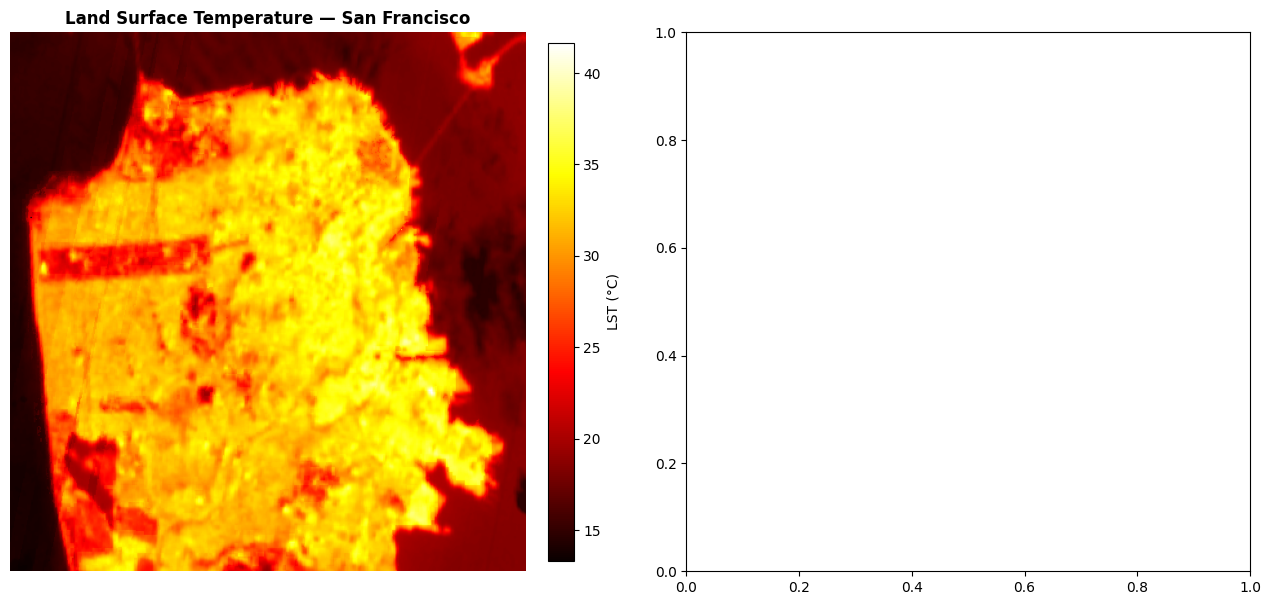

In [40]:
# ---------- 7.3  Risk map ----------
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# LST
ax = axes[0]
lst_display = np.where(lst_layer < -10, np.nan, lst_layer)
im = ax.imshow(lst_display, cmap='hot', aspect='auto')
ax.set_title(f'Land Surface Temperature — {CITY_NAME}', fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='LST (°C)')

# Risk classification
ax = axes[1]
cmap_risk = mcolors.ListedColormap(['#2ecc71', '#f39c12', '#e74c3c'])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, cmap_risk.N)
display_risk = np.where(count_map[..., 0] == 0, np.nan, risk_class_map)
im2 = ax.imshow(display_risk, cmap=cmap_risk, norm=norm, aspect='auto')
ax.set_title(f'U-Net Heat Risk Classification — {CITY_NAME}', fontweight='bold')
ax.axis('off')
cbar = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.suptitle(f'Urban Heat Risk — {CITY_NAME} ({START_DATE[:4]})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_risk_map.png', dpi=300, bbox_inches='tight')
print(f"  ✓ 03_risk_map.png")
plt.close()


NameError: name 'cmap_risk' is not defined

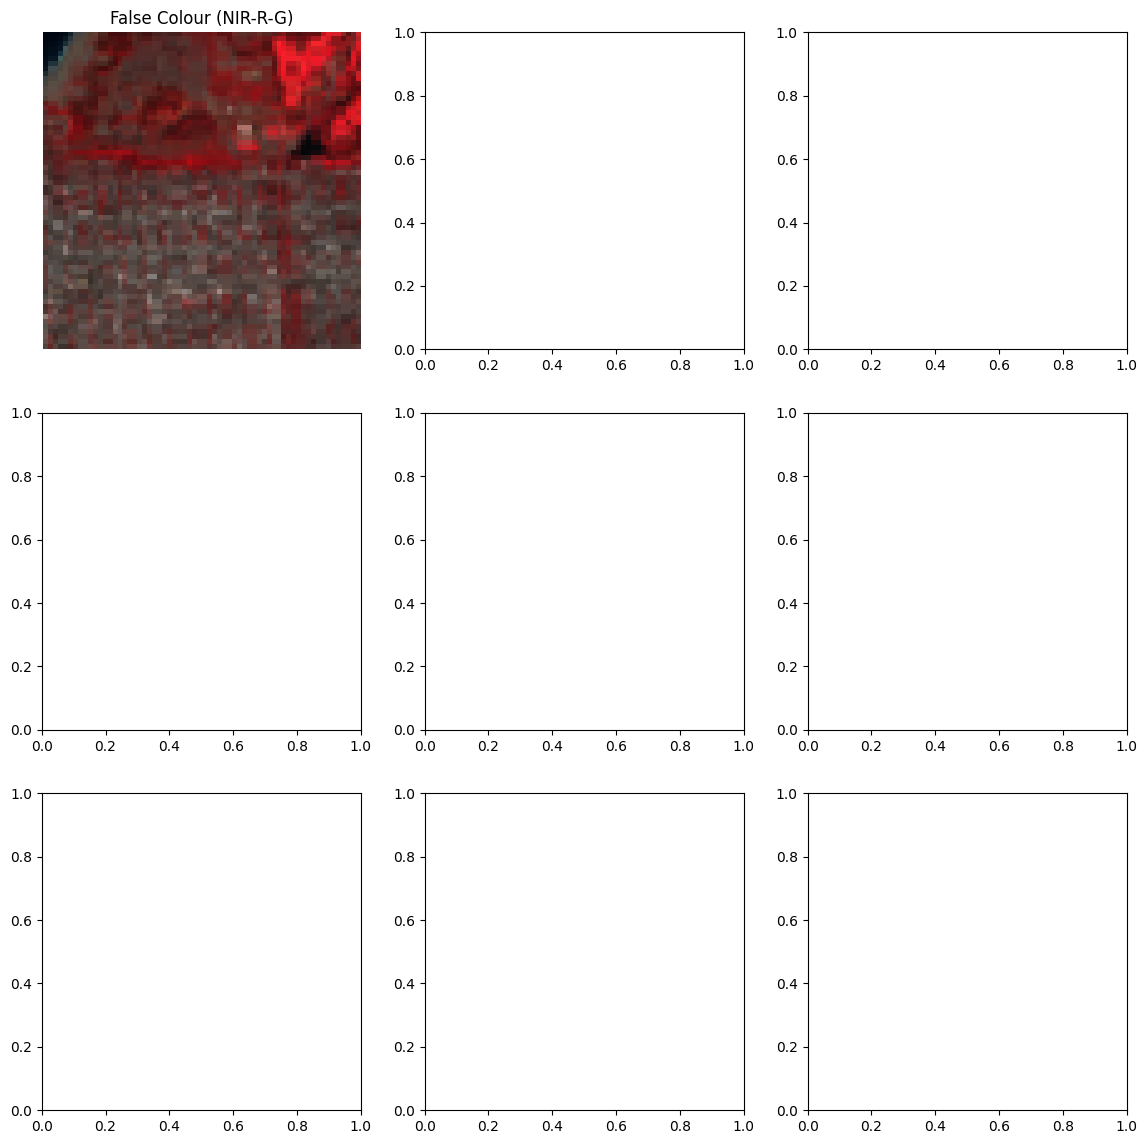

In [41]:
# ---------- 7.4  U-Net example predictions ----------
fig, axes = plt.subplots(3, 3, figsize=(14, 14))

for row in range(3):
    i = test_idx[row]  # pick a test patch

    # Original spectral (false-colour NIR-R-G)
    ax = axes[row, 0]
    nir_idx = FEATURE_BANDS.index('NIR')
    red_idx = FEATURE_BANDS.index('Red')
    grn_idx = FEATURE_BANDS.index('Green')
    fc = np.stack([patches_X[i,:,:,nir_idx],
                   patches_X[i,:,:,red_idx],
                   patches_X[i,:,:,grn_idx]], axis=-1)
    fc = (fc - fc.min()) / (fc.max() - fc.min() + 1e-8)
    ax.imshow(fc)
    ax.set_title('False Colour (NIR-R-G)' if row == 0 else '')
    ax.axis('off')
    if row == 0: ax.set_ylabel('Patch', fontsize=12)

    # Ground truth risk
    ax = axes[row, 1]
    ax.imshow(Ys_test[row].argmax(-1), cmap=cmap_risk, norm=norm)
    ax.set_title('Ground Truth Risk' if row == 0 else '')
    ax.axis('off')

    # Predicted risk
    ax = axes[row, 2]
    pred_i = unet.predict(X_test[row:row+1], verbose=0)[0]
    ax.imshow(pred_i.argmax(-1), cmap=cmap_risk, norm=norm)
    ax.set_title('U-Net Prediction' if row == 0 else '')
    ax.axis('off')

plt.suptitle('U-Net Segmentation Examples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_unet_examples.png', dpi=300, bbox_inches='tight')
print(f"  ✓ 04_unet_examples.png")
plt.close()

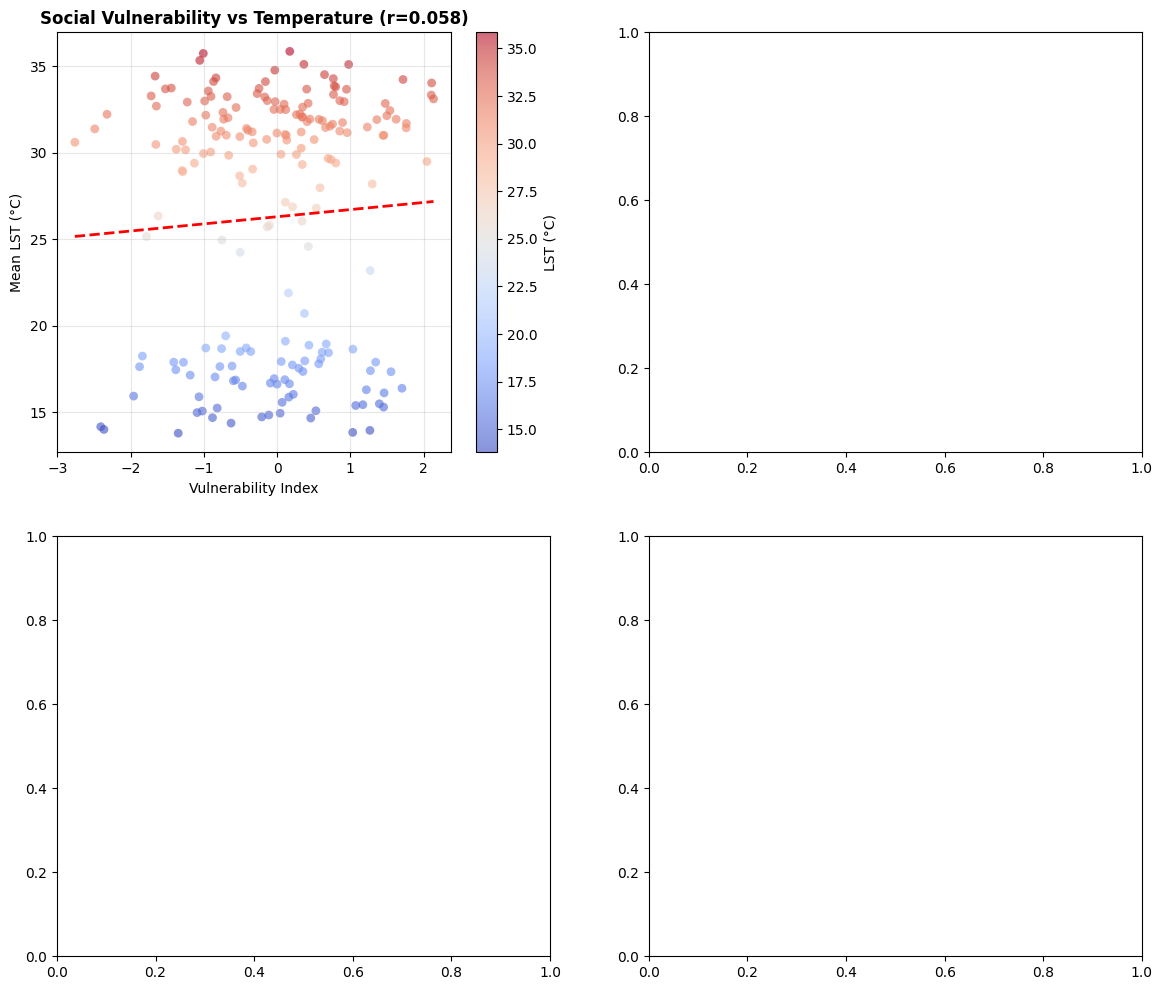

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Vulnerability vs LST
ax = axes[0, 0]
sc = ax.scatter(census_df['vulnerability_index'], census_df['mean_lst'],
                c=census_df['mean_lst'], cmap='coolwarm', alpha=0.6, s=40, edgecolors='none')
z = np.polyfit(census_df['vulnerability_index'], census_df['mean_lst'], 1)
p = np.poly1d(z)
x_line = np.linspace(census_df['vulnerability_index'].min(),
                     census_df['vulnerability_index'].max(), 50)
ax.plot(x_line, p(x_line), 'r--', lw=2)
ax.set_xlabel('Vulnerability Index')
ax.set_ylabel('Mean LST (°C)')
ax.set_title(f'Social Vulnerability vs Temperature (r={corr:.3f})', fontweight='bold')
ax.grid(alpha=0.3)
plt.colorbar(sc, ax=ax, label='LST (°C)')

In [46]:
# Income vs LST
ax = axes[0, 1]
sc = ax.scatter(census_df['median_income']/1000, census_df['mean_lst'],
                c=census_df['mean_lst'], cmap='coolwarm', alpha=0.6, s=40, edgecolors='none')
ax.set_xlabel('Median Income ($k)')
ax.set_ylabel('Mean LST (°C)')
ax.set_title(f'Income vs Temperature (r={corr_inc:.3f})', fontweight='bold')
ax.grid(alpha=0.3)


In [47]:
# Box plot: high vs low vulnerability
ax = axes[1, 0]
box_data = [low_vuln['mean_lst'].values, high_vuln['mean_lst'].values]
bp = ax.boxplot(box_data, labels=['Low Vulnerability\n(Q1)', 'High Vulnerability\n(Q4)'],
                patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
ax.set_ylabel('Mean LST (°C)')
ax.set_title('Temperature by Vulnerability Quartile', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

In [48]:
# Risk class distribution by vulnerability
ax = axes[1, 1]
vuln_q = pd.qcut(census_df['vulnerability_index'], 4, labels=['Q1\n(Low)', 'Q2', 'Q3', 'Q4\n(High)'])
risk_by_vuln = census_df.groupby(vuln_q)['mean_risk'].mean()
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
ax.bar(risk_by_vuln.index, risk_by_vuln.values, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Mean Risk Score (0=Low, 2=High)')
ax.set_xlabel('Vulnerability Quartile')
ax.set_title('Heat Risk by Vulnerability Group', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.suptitle(f'Environmental Justice Analysis — {CITY_NAME}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_environmental_justice.png', dpi=300, bbox_inches='tight')
print(f"  ✓ 05_environmental_justice.png")
plt.close()

  ✓ 05_environmental_justice.png


# **8. SUMMARY**

In [49]:
print(f"""
Study Area: {CITY_NAME}
Period:     {START_DATE} — {END_DATE}
Resolution: {DOWNLOAD_SCALE} m
Patches:    {len(patches_X)} ({PATCH_SIZE}×{PATCH_SIZE})

──────────────────────────────────
CNN REGRESSION (LST Prediction)
  MAE  = {reg_mae:.2f} °C
  RMSE = {reg_rmse:.2f} °C
  R²   = {reg_r2:.3f}

U-NET SEGMENTATION (Heat Risk)
  Accuracy = {seg_acc:.3f}
  IoU per class:""")

for c_i in range(N_CLASSES):
    intersection = ((pred_cls == c_i) & (true_cls == c_i)).sum()
    union        = ((pred_cls == c_i) | (true_cls == c_i)).sum()
    iou = intersection / (union + 1e-8)
    print(f"    {class_names[c_i]:12s}: {iou:.3f}")

print(f"""
──────────────────────────────────
ENVIRONMENTAL JUSTICE
  Vulnerability–LST correlation: r = {corr:.3f} (p = {pval:.4f})
  High-vuln mean LST: {high_vuln['mean_lst'].mean():.1f} °C
  Low-vuln mean LST:  {low_vuln['mean_lst'].mean():.1f} °C
  Gap: {high_vuln['mean_lst'].mean() - low_vuln['mean_lst'].mean():.1f} °C

──────────────────────────────────
HIGH-RISK AREAS
  {high_risk_pct:.1f}% of city classified as high heat risk
  Risk thresholds: < {t_low:.1f} °C (low) | < {t_high:.1f} °C (med) | ≥ {t_high:.1f} °C (high)

Outputs saved to: {OUTPUT_DIR}/
  01_training_curves.png
  02_cnn_regression.png
  03_risk_map.png
  04_unet_examples.png
  05_environmental_justice.png
""")


Study Area: San Francisco
Period:     2025-06-01 — 2025-12-31
Resolution: 30 m
Patches:    216 (64×64)

──────────────────────────────────
CNN REGRESSION (LST Prediction)
  MAE  = 1.07 °C
  RMSE = 1.25 °C
  R²   = 0.963

U-NET SEGMENTATION (Heat Risk)
  Accuracy = 0.906
  IoU per class:
    Low Risk    : 0.984
    Medium Risk : 0.743
    High Risk   : 0.774

──────────────────────────────────
ENVIRONMENTAL JUSTICE
  Vulnerability–LST correlation: r = 0.058 (p = 0.4244)
  High-vuln mean LST: 27.1 °C
  Low-vuln mean LST:  26.0 °C
  Gap: 1.1 °C

──────────────────────────────────
HIGH-RISK AREAS
  32.3% of city classified as high heat risk
  Risk thresholds: < 19.7 °C (low) | < 31.6 °C (med) | ≥ 31.6 °C (high)

Outputs saved to: ./sf_heat_output/
  01_training_curves.png
  02_cnn_regression.png
  03_risk_map.png
  04_unet_examples.png
  05_environmental_justice.png

